# M5 Forecasting 
## Estimate the unit sales of Walmart retail goods
- All information is contained in the link below.
- Link : https://mofc.unic.ac.cy/m5-competition/
- 참고 코드 출처 
- https://www.kaggle.com/sidharthkumar/ma-model-new-baseline-0-86331
- https://www.kaggle.com/chocozzz/the-m5-competition-guidelines


### 본 커널은 M5 competition을 처음 접하는 Korean Starter들을 위한 커널입니다.
### 대부분의 내용은 이미 공개되어 있는 노트북의 내용을 이해하기 쉽게 한글로 바꿔놓은 커널입니다 참고 부탁드립니다!

### *데이터를 이해함에 있어서 도움을 주신 김현우님 좋은커널 감사합니다! :)*

![](https://media.foxbusiness.com/BrightCove/854081161001/201906/438/854081161001_6044984334001_6044980817001-vs.jpg)

In [1]:
import numpy as np 
import pandas as pd 
import plotnine 
import matplotlib.pyplot as plt
import seaborn as sns
import os

from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

%matplotlib inline

# Introduction
## Dataset

- calendar.csv - 제품이 판매 되는 날짜에 대한 정보가 포함되어 있음.
- sales_train_validation.csv - 제품과 매장에 따른 과거 일일 판매 데이터가 포함되어 있음. [d_1 - d_1913]
- sample_submission.csv - submission 형식 파일
- sell_prices.csv - 매장 및 날짜별로 판매되는 제품의 가격에 대한 정보가 포함되어 있음.
- sales_train_evaluation.csv - **Available once month before competition deadline**. Will include sales [d_1 - d_1941]

In [2]:
df_train = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
df_sell = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
df_calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
sub = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")

## 데이터를 이해하기 쉽게 그림으로 확인

![image.png](https://github.com/choco9966/Kaggle/blob/master/M5%20Forecasting/image/overview.PNG?raw=true)

![image.png](https://github.com/choco9966/Kaggle/blob/master/M5%20Forecasting/image/aggtable.PNG?raw=true)

In [3]:
print("Unit sales of all products, aggregated for each state", df_train['state_id'].nunique())
print("Unit sales of all products, aggregated for each store", df_train['store_id'].nunique())
print("Unit sales of all products, aggregated for each category", df_train['cat_id'].nunique())
print("Unit sales of all products, aggregated for each department", df_train['dept_id'].nunique())
print("Unit sales of all products, aggregated for each State and category", df_train['state_id'].nunique() * df_train['cat_id'].nunique())
print("Unit sales of all products, aggregated for each State and department", df_train['state_id'].nunique() * df_train['dept_id'].nunique())
print("Unit sales of all products, aggregated for each store and category", df_train['store_id'].nunique() * df_train['cat_id'].nunique())
print("Unit sales of all products, aggregated for each store and department", df_train['store_id'].nunique() * df_train['dept_id'].nunique())
print("Unit sales of all products, aggregated for each  and category", df_train['dept_id'].nunique() * df_train['cat_id'].nunique())
print("Unit sales of product x, aggregated for all stores/states", df_train['item_id'].nunique())
print("Unit sales of product x, aggregated for all states", df_train['item_id'].nunique() * df_train['state_id'].nunique())
print("Unit sales of product x, aggregated for all stores", df_train['item_id'].nunique() * df_train['store_id'].nunique())

Unit sales of all products, aggregated for each state 3
Unit sales of all products, aggregated for each store 10
Unit sales of all products, aggregated for each category 3
Unit sales of all products, aggregated for each department 7
Unit sales of all products, aggregated for each State and category 9
Unit sales of all products, aggregated for each State and department 21
Unit sales of all products, aggregated for each store and category 30
Unit sales of all products, aggregated for each store and department 70
Unit sales of all products, aggregated for each  and category 21
Unit sales of product x, aggregated for all stores/states 3049
Unit sales of product x, aggregated for all states 9147
Unit sales of product x, aggregated for all stores 30490


## File 1: "calendar.csv"
제품이 판매 되는 날짜에 대한 정보가 포함되어 있음.
- date: “y-m-d” 형식의 날짜
- wm_yr_wk: 해당 날짜가 속한 주(week)의 ID
- weekday: 요일
- wday: 요일의 ID, 토요일 부터 시작
- month: 해당 날짜의 달(month)
- year: 해당 날짜의 년도(year)
- event_name_1: 해당 날짜에 이벤트가 포함되어 있을 경우, 이벤트의 이름
- event_type_1: 해당 날짜에 이벤트가 포함되어 있을 경우, 이벤트의 타입
- event_name_2: 해당 날짜에 두번째 이벤트가 포함되어 있을 경우, 이벤트의 이름
- event_type_2: 해당 날짜에 두번째 이벤트가 포함되어 있을 경우, 이벤트의 타입
- snap_CA, snap_TX, and snap_WI: 해당 날짜에 CA, TX 또는 WI의 스토어가 SNAP2 구매를 허용하는지 여부를 나타내는 이진 변수(0 또는 1). 1은 SNAP 구매가 허용됨을 나타낸다.

In [4]:
df_calendar.head(8)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1


### Event information 

- 이벤트 1, 2에 대한 정보를 시각화 해봅니다. 
- Countplot을 이용하여 어떤 이벤트가 얼마나 있는지 확인해봅니다.

In [5]:
df_calendar[df_calendar['event_name_1'].notnull()].head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,NaN,NaN,0,0,1
23,2011-02-21,11104,Monday,3,2,2011,d_24,PresidentsDay,National,NaN,NaN,0,0,0
39,2011-03-09,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,NaN,NaN,1,1,1
46,2011-03-16,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,NaN,NaN,0,0,0


Text(0, 0.5, 'Event Name')

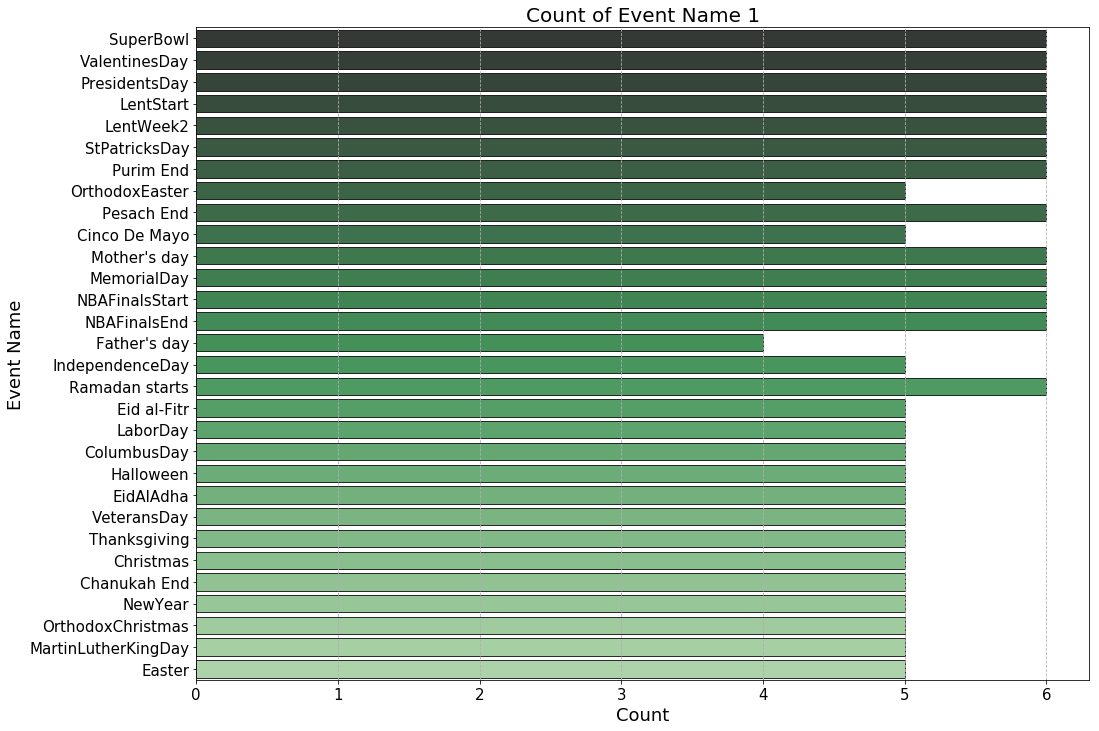

In [6]:
f, ax = plt.subplots(figsize = (16, 12))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "event_name_1", data = df_calendar, ax = ax, palette = "Greens_d",edgecolor='black', linewidth=0.8)
plt.title("Count of Event Name 1", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Count", size = 18)
plt.ylabel("Event Name", size = 18)

Text(0, 0.5, 'Event Type')

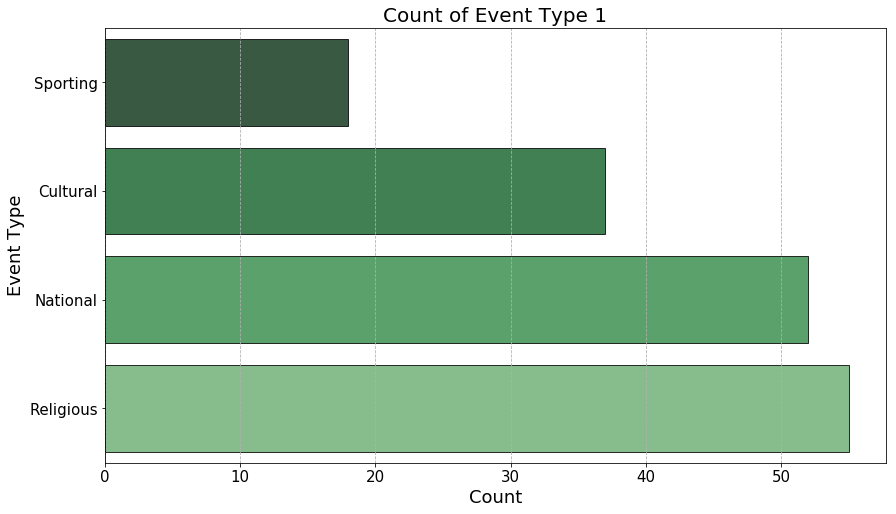

In [7]:
f, ax = plt.subplots(figsize = (14, 8))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "event_type_1", data = df_calendar, ax = ax, palette = "Greens_d",edgecolor='black', linewidth=0.8)
plt.title("Count of Event Type 1", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Count", size = 18)
plt.ylabel("Event Type", size = 18)

In [8]:
df_calendar[df_calendar['event_name_2'].notnull()].head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
85,2011-04-24,11113,Sunday,2,4,2011,d_86,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
827,2013-05-05,11315,Sunday,2,5,2013,d_828,OrthodoxEaster,Religious,Cinco De Mayo,Cultural,1,1,1
1177,2014-04-20,11412,Sunday,2,4,2014,d_1178,Easter,Cultural,OrthodoxEaster,Religious,0,0,0
1233,2014-06-15,11420,Sunday,2,6,2014,d_1234,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [9]:
print("event_name_2 notnull shape : ", df_calendar[df_calendar['event_name_2'].notnull()].shape)
print("event_name_1 and 2 notnull shape : ", df_calendar[(df_calendar['event_name_2'].notnull()) & (df_calendar['event_name_1'].notnull())].shape)

event_name_2 notnull shape :  (5, 14)
event_name_1 and 2 notnull shape :  (5, 14)


In [10]:
df_calendar.loc[(df_calendar['event_name_2'].notnull()) & (df_calendar['event_name_1'].notnull())]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
85,2011-04-24,11113,Sunday,2,4,2011,d_86,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
827,2013-05-05,11315,Sunday,2,5,2013,d_828,OrthodoxEaster,Religious,Cinco De Mayo,Cultural,1,1,1
1177,2014-04-20,11412,Sunday,2,4,2014,d_1178,Easter,Cultural,OrthodoxEaster,Religious,0,0,0
1233,2014-06-15,11420,Sunday,2,6,2014,d_1234,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [11]:
df_calendar.loc[df_calendar['event_name_2'].notnull()]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
85,2011-04-24,11113,Sunday,2,4,2011,d_86,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
827,2013-05-05,11315,Sunday,2,5,2013,d_828,OrthodoxEaster,Religious,Cinco De Mayo,Cultural,1,1,1
1177,2014-04-20,11412,Sunday,2,4,2014,d_1178,Easter,Cultural,OrthodoxEaster,Religious,0,0,0
1233,2014-06-15,11420,Sunday,2,6,2014,d_1234,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


### 위의 코드들을 보면 두번째 이벤트에 해당되는 관측치는 전부 첫번째 이벤트가 선행되어 있음을 알 수 있습니다.

Text(0, 0.5, 'Event Name')

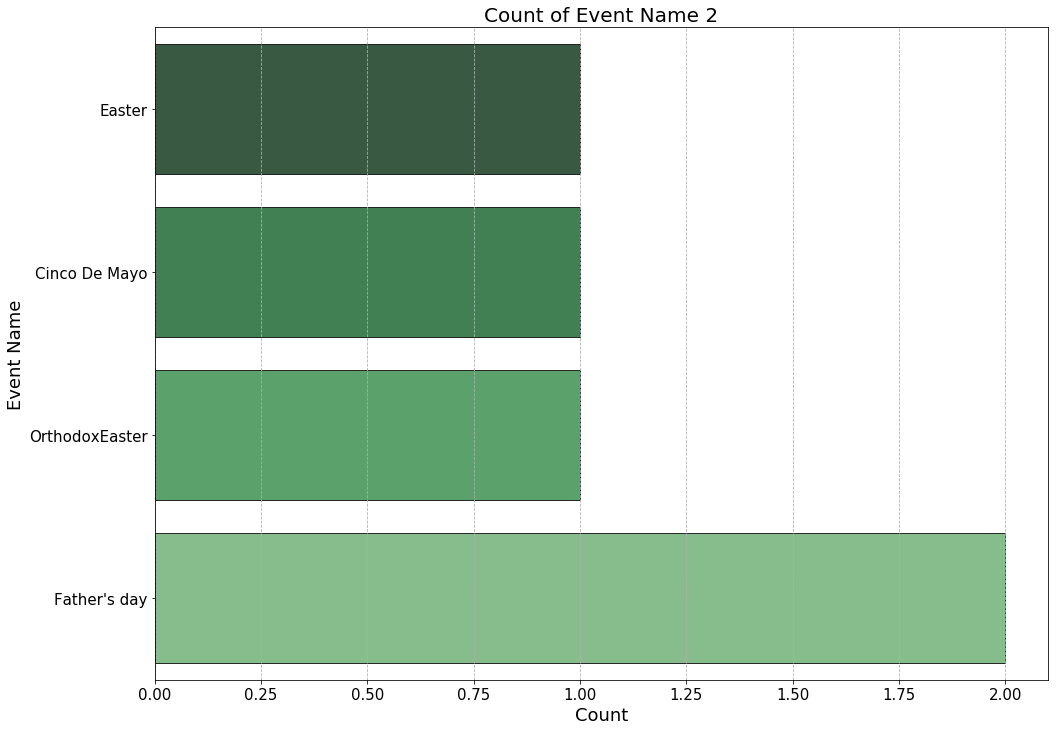

In [12]:
f, ax = plt.subplots(figsize = (16, 12))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "event_name_2", data = df_calendar, ax = ax, palette = "Greens_d",edgecolor='black', linewidth=0.8)
plt.title("Count of Event Name 2", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Count", size = 18)
plt.ylabel("Event Name", size = 18)

Text(0, 0.5, 'Event Type')

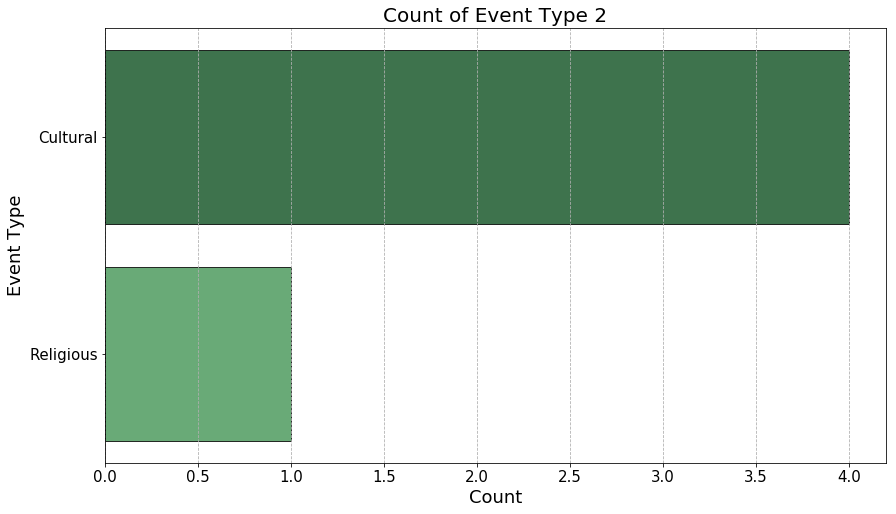

In [13]:
f, ax = plt.subplots(figsize = (14, 8))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "event_type_2", data = df_calendar, ax = ax, palette = "Greens_d",edgecolor='black', linewidth=0.8)
plt.title("Count of Event Type 2", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Count", size = 18)
plt.ylabel("Event Type", size = 18)

## File 2: "sell_prices.csv"
매장 및 날짜별로 판매되는 제품의 가격에 대한 정보가 포함되어 있음.
- store_id: 제품이 판매되는 매장의 ID
- item_id: 제품의 ID
- wm_yr_wk: 해당 주(week)의 ID
- sell_price: 지정된 주(week)/매장의 제품 가격. 가격은 주(week) 별로 제공된다(일주일의 평균). 사용할 수 없는 경우 이는 해당 제품이 검사된 주 중에 판매되지 않았음을 의미한다. 
  (주 단위로 가격이 일정하지만 시간이 지남에 따라 변할 수 있다는 점에 유의한다.)

In [14]:
print(df_sell.shape)
df_sell.head()

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [15]:
df_sell["sell_price"].isnull().sum()

0

## File 3: “sales_train.csv”

제품과 매장에 따른 과거 일일 판매 데이터가 포함되어 있음. 
- item_id: 제품의 ID.
- dept_id: 제품이 속한 부서의 ID.(cat_id의 하위 카테고리)
- cat_id: 제품이 속한 카테고리의 ID.
- store_id: 제품이 판매되는 매장의 ID
- state_id: 매장이 속해있는 주(state)
- d_1, d_2, …, d_i, … d_1941: i일에 판매된 단위 수. (2011-01-29일부터 시작)

In [16]:
df_train["cat_id"].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [17]:
df_train["dept_id"].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [18]:
print(df_train.shape)
df_train.head()

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## Submission File

- 각 행에 대해 판매되는 품목의 예측일수 28일(F1-F28)을 예측하고 있습니다. 
- validation행의 경우 이는 d_1914 - d_1941에 해당하며, evaluation(test)행의 경우 d_1942 - d_1969에 해당됩니다.  (참고: 경기가 종료되기 한 달 전에 validation행의 값이 제공됩니다)

In [19]:
sub["id"].unique

<bound method Series.unique of 0        HOBBIES_1_001_CA_1_validation
1        HOBBIES_1_002_CA_1_validation
2        HOBBIES_1_003_CA_1_validation
3        HOBBIES_1_004_CA_1_validation
4        HOBBIES_1_005_CA_1_validation
                     ...              
60975      FOODS_3_823_WI_3_evaluation
60976      FOODS_3_824_WI_3_evaluation
60977      FOODS_3_825_WI_3_evaluation
60978      FOODS_3_826_WI_3_evaluation
60979      FOODS_3_827_WI_3_evaluation
Name: id, Length: 60980, dtype: object>

In [20]:
sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA for Time Series

In [21]:
d_cols = [c for c in df_train.columns if 'd_' in c] 

# d_로 시작하는 columns

### 제품별로 시계열 시각화

1. 시각화할 제품을 선택
 
2. ID를 인덱스로 설정, 판매 데이터 열만 보관

3. 열로 변신

4. plot 그리기 

In [22]:
len(df_train["id"].unique())

30490

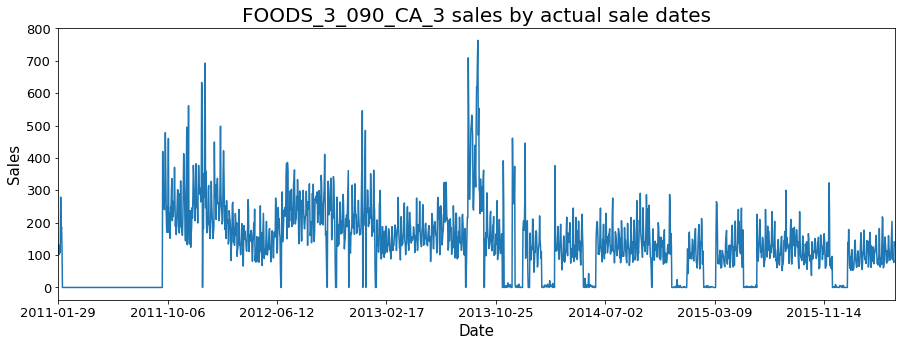

In [23]:
df_item = df_train.loc[df_train['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T # 시계열 시각화를 위해 "d_" 변수들과 하나의 제품 변수를 골라서 transpose해준다. 
df_item = df_item.rename(columns={8412:'FOODS_3_090_CA_3'}) # 인덱싱 했던 행의 번호로 되어있는 column name을 제품의 id로 바꿔준다.
df_item = df_item.reset_index().rename(columns={'index': 'd'}) # 인덱스 이름을 "d"로 바꿔준다.
df_item = df_item.merge(df_calendar, how='left', validate='1:1') # 위에서 만들어준 데이터프레임과 calendar 데이터프레임을 병합한다. (d로 만들어준 컬럼과 date 컬럼을 사용하기 위함)
df_item.set_index('date')['FOODS_3_090_CA_3'].plot(figsize=(15, 5),
                                                   color=next(color_cycle))

plt.title('FOODS_3_090_CA_3 sales by actual sale dates', size = 20)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.xlabel("Date", size = 15)
plt.ylabel("Sales", size = 15)
plt.show()

### 시간 변수에 따른 판매량

- 요일

- 월

- 연도

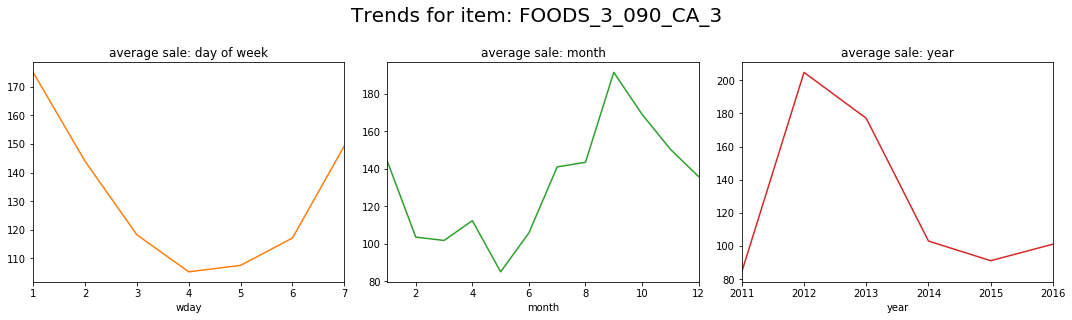

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

df_item.groupby('wday').mean()['FOODS_3_090_CA_3'].plot(kind='line', title='average sale: day of week', color=next(color_cycle), ax=ax1)
# 요일에 따른 판매량 확인

df_item.groupby('month').mean()['FOODS_3_090_CA_3'].plot(kind='line', title='average sale: month', color=next(color_cycle), ax=ax2)
# 월별 판매량 확인

df_item.groupby('year').mean()['FOODS_3_090_CA_3'].plot(kind='line', title='average sale: year', color=next(color_cycle), ax=ax3)
# 연도별 판매량 확인

fig.suptitle('Trends for item: FOODS_3_090_CA_3', size=20, y=1.1)
plt.tight_layout()
plt.show()

### 제품 유형에 따른 판매량 합계

- Hobbies (취미용품)
 
- Household (가정용품)

- Foods (식료품)

In [25]:
item_id_split = df_sell['item_id'].str.split('_', expand=True)
item_id_split[0].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

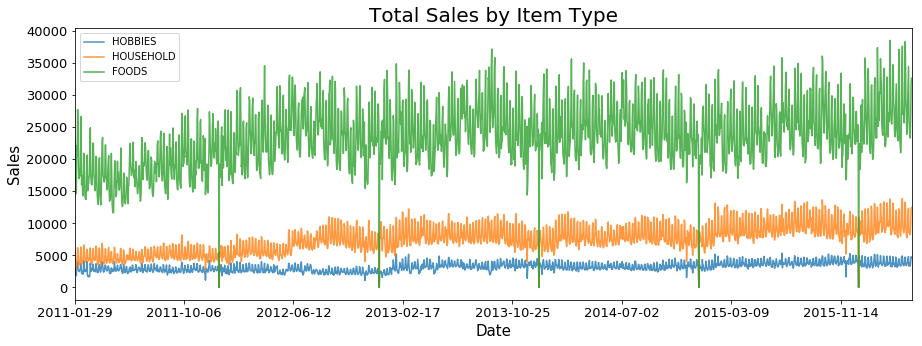

In [26]:
past_sales = df_train.set_index('id')[d_cols].T.merge(df_calendar.set_index('d')['date'], left_index=True, right_index=True, validate='1:1').set_index('date')

item_type_list = item_id_split[0].unique()

for i in item_type_list:
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5), alpha=0.8)

plt.title('Total Sales by Item Type', size = 20)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.xlabel("Date", size = 15)
plt.ylabel("Sales", size = 15)
plt.legend(item_type_list)
plt.show()

# 식료품의 판매량이 압도적으로 높고, 그 다음이 가정용품 그리고 취미용품 순서인 것을 알 수 있다.

### 매장 별 판매량

- 매장은 10개의 unique한 값들로 이루어져 있다. 

- 시간에 따른 상점들의 판매량을 시각화 해본다.

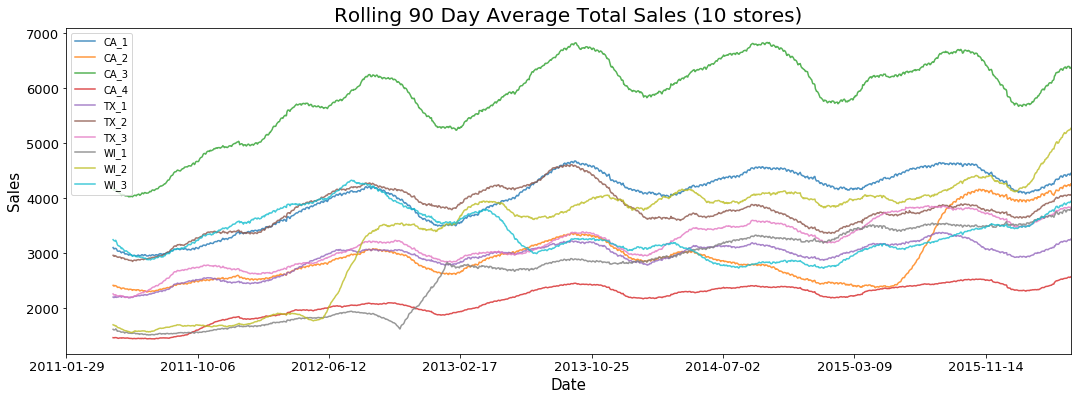

In [27]:
store_list = df_sell['store_id'].unique()

for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items].sum(axis=1).rolling(90).mean().plot(figsize=(18, 6), alpha=0.8) # .rolling은 이동평균을 위한 함수

    
plt.title('Rolling 90 Day Average Total Sales (10 stores)', size = 20)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.xlabel("Date", size = 15)
plt.ylabel("Sales", size = 15)    
plt.legend(store_list)
plt.show()

# Simple MA Model

- MA란? 
- 일변량 정상 시계열 모형으로서 이동평균 모형이라고 부른다. (Moving Average model)
- q차 MA(Moving Average) 모형 MA(q)는 확률과정의 현재 값 Yt이 백색 잡음의 현재 값 ϵt부터 q-시간 지연된 ϵt−q까지 q+1개 항의 선형 가중합인 확률과정 모형이다. MA(q)라고 쓴다.

### Yt=ϵt+θ1ϵt−1+θ2ϵt−2+⋯+θqϵt−q

- 가장 간단한 형태로는 바로 직전 데이터가 다음 데이터에 영향을 준다고 가정한 MA(1)모형이다.
- MA(2)모형은 다음과 같이 백색 잡음의 현재 값과 1-시간 지연된 과거 값, 그리고 2-시간 지연된 과거 값의 선형 가중합으로 나타난다.
- [참고: (MA)모형 - 데이터사이언스 스쿨](https://datascienceschool.net/view-notebook/f1b89d145ef14bca8e5b6f1800985d52/)

In [28]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]
time_series_data = df_train[time_series_columns]

In [29]:
MA_x = 34  #play here

forecast = time_series_data.iloc[:, -MA_x:].copy()
for i in range(28):
    forecast['F'+str(i+1)] = forecast.iloc[:, -MA_x:].mean(axis=1)    
    
forecast = forecast[['F'+str(i+1) for i in range(28)]]
forecast.head(20)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,1.000000,0.970588,0.940311,0.967968,0.967026,0.966056,0.965057,0.964030,0.992383,1.021571,...,1.010583,1.010894,0.981803,1.010680,1.040405,1.071006,1.073094,1.075244,1.018633,1.048593
1,0.176471,0.181661,0.187004,0.163092,0.138477,0.113138,0.087054,0.060203,0.061974,0.063796,...,0.082813,0.085248,0.087756,0.090337,0.092994,0.095729,0.098544,0.101443,0.104426,0.107498
2,0.529412,0.544983,0.561012,0.577512,0.565086,0.552294,0.568538,0.585260,0.602473,0.620193,...,0.740786,0.762574,0.785002,0.808091,0.831858,0.826913,0.792410,0.756893,0.749742,0.712970
3,2.117647,2.150519,2.125534,2.040991,2.101020,1.986344,1.868296,1.923246,1.979812,2.038041,...,2.215192,2.133286,2.078383,2.080688,2.141885,2.116646,2.178901,2.213574,2.278679,2.198640
4,1.235294,1.183391,1.188785,1.223749,1.259742,1.296793,1.334934,1.344785,1.384337,1.307406,...,1.315412,1.324689,1.334239,1.314658,1.353324,1.363716,1.374413,1.356014,1.366485,1.377264
5,0.764706,0.728374,0.749796,0.683614,0.674309,0.664729,0.625457,0.643852,0.633378,0.563771,...,0.608907,0.626816,0.645252,0.634818,0.535842,0.551603,0.567826,0.584527,0.572307,0.589140
6,0.352941,0.363322,0.374008,0.355596,0.366055,0.376821,0.387904,0.369901,0.321957,0.331427,...,0.394191,0.376373,0.358031,0.368561,0.349989,0.360283,0.370880,0.381788,0.393017,0.404576
7,7.441176,7.277682,7.197613,7.350484,7.566675,7.789224,8.018319,8.254152,8.173392,8.266727,...,6.746212,6.591689,6.667915,6.716971,6.855705,6.822050,6.905051,7.108141,7.317204,7.503004
8,0.735294,0.756920,0.779183,0.802100,0.825691,0.849976,0.874975,0.900710,0.868378,0.893918,...,0.949238,0.947745,0.946208,0.974037,0.796803,0.820238,0.844363,0.869197,0.894762,0.891667
9,0.558824,0.575260,0.592179,0.609596,0.627525,0.645982,0.664981,0.684540,0.675261,0.665710,...,0.498231,0.512884,0.527969,0.514086,0.529206,0.544771,0.560794,0.547876,0.563990,0.580578


In [30]:
validation_ids = df_train['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]
ids = np.concatenate([validation_ids, evaluation_ids])
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast] * 2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)
predictions.to_csv('submission.csv', index=False)

In [31]:
predictions.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.000000,0.970588,0.940311,0.967968,0.967026,0.966056,0.965057,0.964030,0.992383,...,1.010583,1.010894,0.981803,1.010680,1.040405,1.071006,1.073094,1.075244,1.018633,1.048593
1,HOBBIES_1_002_CA_1_validation,0.176471,0.181661,0.187004,0.163092,0.138477,0.113138,0.087054,0.060203,0.061974,...,0.082813,0.085248,0.087756,0.090337,0.092994,0.095729,0.098544,0.101443,0.104426,0.107498
2,HOBBIES_1_003_CA_1_validation,0.529412,0.544983,0.561012,0.577512,0.565086,0.552294,0.568538,0.585260,0.602473,...,0.740786,0.762574,0.785002,0.808091,0.831858,0.826913,0.792410,0.756893,0.749742,0.712970
3,HOBBIES_1_004_CA_1_validation,2.117647,2.150519,2.125534,2.040991,2.101020,1.986344,1.868296,1.923246,1.979812,...,2.215192,2.133286,2.078383,2.080688,2.141885,2.116646,2.178901,2.213574,2.278679,2.198640
4,HOBBIES_1_005_CA_1_validation,1.235294,1.183391,1.188785,1.223749,1.259742,1.296793,1.334934,1.344785,1.384337,...,1.315412,1.324689,1.334239,1.314658,1.353324,1.363716,1.374413,1.356014,1.366485,1.377264


## Before competitions
- M4 : https://github.com/Mcompetitions/M4-methods
- Discussion by RDizzl3 : https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133469

## Benchmarks models
code : https://github.com/Mcompetitions/M4-methods

- Naive
- Seaonal Naive
- Simple Exponential Smoothing 
- Moving Averages 
- Croston’s method
- Optimized Croston’s method
- Syntetos-Boylan Approximation
- Teunter-Syntetos-Babai method
- Aggregate-Disaggregate Intermittent Demand Approach
- Intermittent Multiple Aggregation Prediction Algorithm
- Exponential Smoothing
- Exponential Smoothing with eXplanatory variables 
- AutoRegressive Integrated Moving Average
- AutoRegressive Integrated Moving Average with eXplanatory variables 
- Multi-Layer Perceptron
- Random Forest
- Global Multi-Layer Perceptron
- Global Random Forest (GRF)